# Project Description

#### This is a project based on the winery data downloaded from Kaggle website
#### The data was scraped from WineEnthusiast  http://www.wineenthusiast.com/   during the week of June 15th, 2017
#### We are trying to predict the wine rating 'points' based on the other features

# Dataset Details

## The data consists of 10 fields:

- #### Country: The country that the wine is from
- #### Description: Few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- #### Designation: The vineyard within the winery where the grapes that made the wine are from
- #### Points: The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
- #### Price: The cost for a bottle of the wine
- #### Province: The province or state that the wine is from
- #### Region 1: The wine growing area in a province or state (ie Napa)
- #### Region 2: Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
- #### Variety: the type of grapes used to make the wine (ie Pinot Noir)
- #### Winery: The winery that made the wine

### Data Types of the columns

- country    :    object
- description:    object
- designation:    object
- points     :    int64
- price      :    float64
- province   :    object
- region_1   :    object
- region_2   :    object
- variety    :    object
- winery     :    object

### Import the dependencies

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets import interactive, Layout, Textarea, Dropdown, Label
HTML('<style> .widget-hbox .widget-label { max-width:350ex; text-align:left} </style>')
%matplotlib inline  

### Initial Overview of Data

In [2]:
init_data = pd.read_csv("winemag-data_first150k.csv")
print("Length of dataframe before duplicates are removed:", len(init_data))

Length of dataframe before duplicates are removed: 150930


#### Data Cleansing

In [3]:
wineData = init_data[init_data.duplicated('description', keep=False)]
print("Length of dataframe after duplicates are removed:", len(wineData))
wineData = wineData[['province','variety','country','price','points','region_1','winery']]
wineData = wineData.dropna(subset=['province','variety','country','price','points','region_1','winery'], how='any')
wineData.drop_duplicates(keep='first')
print("Length of dataframe after cleanup:", len(wineData))

Length of dataframe after duplicates are removed: 92393
Length of dataframe after cleanup: 69492


### Exploratory Data Analysis

#### Correlation between Points and Price

Pearson Correlation: (0.49071198316667447, 0.0)
                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                 7.005e+04
Date:                Tue, 30 Jan 2018   Prob (F-statistic):               0.00
Time:                        18:56:13   Log-Likelihood:            -3.8533e+05
No. Observations:               69492   AIC:                         7.707e+05
Df Residuals:                   69491   BIC:                         7.707e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pric

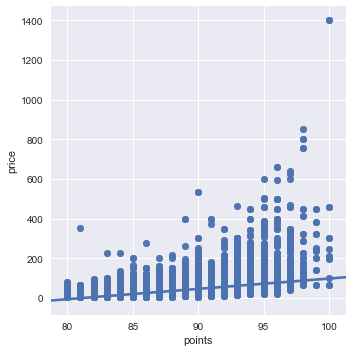

In [4]:
from scipy.stats import pearsonr
import statsmodels.api as sm
print("Pearson Correlation:", pearsonr(wineData.price, wineData.points))
print(sm.OLS(wineData.points, wineData.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=wineData)

#### Correlation between Country and Points

In [5]:
# print("Pearson Correlation:", pearsonr(wineData.country, wineData.points))
# print(sm.OLS(wineData.points, wineData.country).fit().summary())
# sns.lmplot(y = 'country', x='points', data=wineData)

##### Statsmodel could not be used to correlate since 'country' is categorical data(non-numeric) 

##### Hence we will try to use box-plot to show top 5 countries and how their wines are rated.

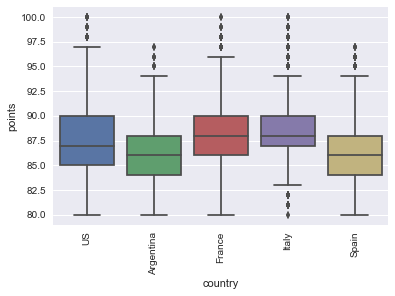

In [6]:
ax = sns.boxplot(
    x='country',
    y='points',
    data=wineData[wineData.country.isin(wineData.country.value_counts().head(5).index)]
)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Correlation between Variety and Points

#### Box  Plot

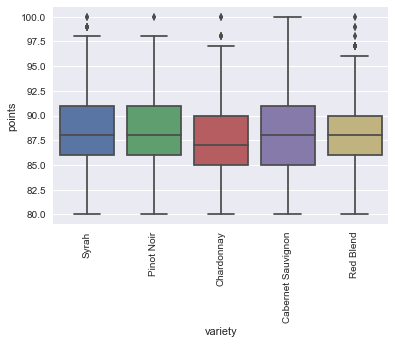

In [7]:
ax = sns.boxplot(
    x='variety',
    y='points',
    data=wineData[wineData.variety.isin(wineData.variety.value_counts().head(5).index)]
)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

#### Violin Plot

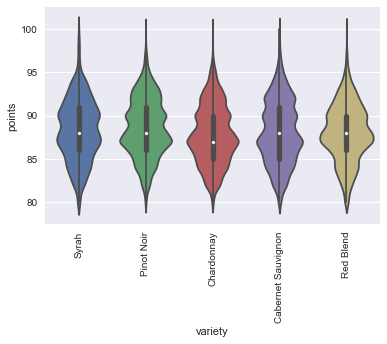

In [8]:
ax = sns.violinplot(
    x='variety',
    y='points',
    data=wineData[wineData.variety.isin(wineData.variety.value_counts()[:5].index)]
)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

#### Bar Plot for count of wines with specific rating

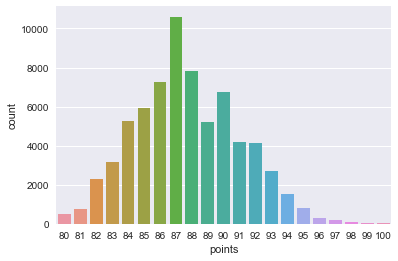

In [9]:
sns.countplot(wineData['points'])

#### Distribution Line Graph for wines less than $200

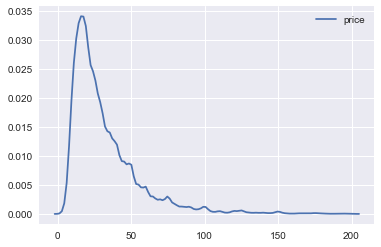

In [10]:
sns.kdeplot(wineData.query('price < 200').price)

## Prediction using a Decision Tree

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=10)

## create the x and y columns
x_unsplit = wineData[['variety', 'price', 'winery', 'region_1']]
y_unsplit = wineData['points']
## one hot encode the data
x_unsplit = pd.get_dummies(x_unsplit, columns=['variety', 'winery', 'region_1'])
print(x_unsplit.shape, y_unsplit.shape)
## get the training and testing data
X_train, X_test, y_train, y_test = train_test_split(x_unsplit, y_unsplit, random_state=1, train_size=0.90)

(69492, 8445) (69492,)


In [12]:
X_train_mean = X_train.fillna({"price": x_unsplit['price'].mean()})
X_test_mean = X_test.fillna({"price":x_unsplit['price'].mean()})
clf.fit(X_train_mean, y_train)

y_predictions = clf.predict(X_test_mean)

# clf.score(y_test,y_predictions)
from sklearn.metrics import accuracy_score
dt_acc = accuracy_score(y_test,y_predictions)
print("R-squared/Accuracy value for Decision Tree:",dt_acc)

R-squared/Accuracy value for Decision Tree: 0.807194244604


#### Using Decision Tree - Accuracy approx 80% 

## Prediction using a Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()

In [14]:
forest_clf.fit(X_train_mean, y_train)
forest_predictions = forest_clf.predict(X_test_mean)
rf_acc = accuracy_score(y_test,forest_predictions)
print("R-squared/Accuracy value for Random Forest:",rf_acc)
# print(rf_acc)

R-squared/Accuracy value for Random Forest: 0.800863309353


#### Using Random Forest - Accuracy approx 79% 

## Set up for Predictions

#### 1. Creating List for categories
#### 2. Defining function for prediction

In [15]:
variety_category = sorted(wineData['variety'].unique().tolist())
winery_category = sorted(wineData['winery'].unique().tolist())
region_1_category = sorted(wineData['region_1'].unique().tolist())

columnList = X_test_mean.columns.tolist()

def add_missing_dummy_columns( d, columns ):
    missing_cols = set( columns ) - set( d.columns )
    for c in missing_cols:
        d[c] = 0
        
def predict_points(varietyVal, priceVal, wineryVal, region1Val):
    df1 = pd.DataFrame({'variety': varietyVal, 'price': priceVal, 'winery': wineryVal, 'region_1': region1Val}, index=[0])
    new_sample = pd.get_dummies(df1)
    add_missing_dummy_columns(new_sample, columnList)
    new_sample1_prd = clf.predict(new_sample)
#     print(new_sample1_prd[0])
    return new_sample1_prd[0]

### Interactive dropdown to select value for Features

#### Definition for the layout for the Input Selection

In [16]:
form_item_layout = Layout(
    display='flex',
    #flex_flow='row',
    justify_content='space-between',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='70%'
)

In [17]:
def f1(variety):
    return variety

def f3(winery):
    return winery

def f4(region_1):
    return region_1

def f5(price):
    return price

variety = interactive(f1,variety=variety_category)
winery = interactive(f3,winery=winery_category)
region_1 = interactive(f4,region_1=region_1_category)
price = interactive(f5, price='10')

display(variety)
display(winery)
display(region_1)
display(price)

In [18]:
selected_variety = variety.result
print(selected_variety)
selected_winery = winery.result
print(selected_winery)
selected_region_1 = region_1.result
print(selected_region_1)
selected_price = float(price.result)
print(selected_price)

Aglianico
1+1=3
Abruzzo
10.0


In [19]:
predict_points(selected_variety,selected_price,selected_winery,selected_region_1)

85

### Filter records which are not used for training the algorithm

In [20]:
wine150k = pd.read_csv("winemag-data_first150k.csv")
print("Length of dataframe before duplicates are removed:", len(wine150k))

wine150k = wine150k.drop('Unnamed: 0',  axis=1)

wine130k = pd.read_csv("winemag-data-130k-v2.csv")
print("Length of dataframe before duplicates are removed:", len(wine130k))

wine130k = wine130k.drop('Unnamed: 0',  axis=1)

df = pd.merge(wine130k, wine150k, how='outer', indicator=True)
onlyIn130kList_allCol = df[df['_merge']=='left_only'][wine130k.columns]

print("Count of Wines in 130k list only (which are not in 150k list):",len(onlyIn130kList_allCol))

onlyIn130kList = onlyIn130kList_allCol[['variety', 'province', 'price', 'winery', 'region_1', 'points']]

uniqueIn130kList = onlyIn130kList[onlyIn130kList.duplicated(keep=False)]

uniqueIn130kList = uniqueIn130kList.drop_duplicates(keep='first')

print("After removing duplicates:",len(uniqueIn130kList))


print("dataset size before removing records with Nan's:",len(uniqueIn130kList))
uniqueIn130kList = uniqueIn130kList.dropna(subset=['province','variety','price','points','region_1'], how='any')
print("dataset size after removing records with Nan's:",len(uniqueIn130kList))


def getDataBetweenRecrds(startIndex, endIndex):
    resRecords = uniqueIn130kList[startIndex:endIndex]
    return resRecords

lastIndex = len(uniqueIn130kList)


Length of dataframe before duplicates are removed: 150930
Length of dataframe before duplicates are removed: 129971
Count of Wines in 130k list only (which are not in 150k list): 79191
After removing duplicates: 9018
dataset size before removing records with Nan's: 9018
dataset size after removing records with Nan's: 7070


In [21]:
def selectRandomWine():
    randomWineIndex = randint(1, lastIndex)
    selectedRecord = getDataBetweenRecrds(randomWineIndex-1,randomWineIndex)
    return selectedRecord

In [22]:
def isValPresent(valToCheck, lstToCheck):
    if valToCheck in lstToCheck:
        return True
    else:
        return False

In [23]:
def canWineBePredicted(variety,winery,region):
    varietyPresent = isValPresent(variety, variety_category)
    wineryPresent = isValPresent(winery, winery_category)
    region_1Present = isValPresent(region, region_1_category)
    if (varietyPresent and wineryPresent and region_1Present):
        return True
    else:
        return False

In [24]:
def selectAllDetails(selectedWine):
    lst1 = []
    onlyIn130kList_allCol.reset_index()
    for x in range(0,len(onlyIn130kList_allCol)):
        if(selectedWine['variety'].values[0] == onlyIn130kList_allCol[x:x+1]['variety'].values[0] and
           selectedWine['winery'].values[0] == onlyIn130kList_allCol[x:x+1]['winery'].values[0] and
           selectedWine['price'].values[0] == onlyIn130kList_allCol[x:x+1]['price'].values[0] and
           selectedWine['points'].values[0] == onlyIn130kList_allCol[x:x+1]['points'].values[0] and
           selectedWine['region_1'].values[0] == onlyIn130kList_allCol[x:x+1]['region_1'].values[0]):
            lst1.append(onlyIn130kList_allCol[x:x+1])
#     print("selected wine details:\n",lst1[0])
#     print(type(lst1[0]))
    return lst1[0]

In [25]:
def selectWineForPrediction(variety_category,winery_category,region_1_category):
    lstVal, retVal = [], []
    selectedWine = selectRandomWine()
    predictWine = canWineBePredicted(selectedWine['variety'].values[0],selectedWine['winery'].values[0],selectedWine['region_1'].values[0])
    if predictWine:
#         print(selectedWine)
        selWine = selectAllDetails(selectedWine)
        lstVal.append(selWine)
        predictedVal = predict_points(selectedWine['variety'].values[0],selectedWine['price'].values[0],selectedWine['winery'].values[0],selectedWine['region_1'].values[0])
        lstVal.append(predictedVal)
        retVal = lstVal
    else:
        retVal = selectWineForPrediction(variety_category,winery_category,region_1_category)
    return retVal

In [26]:
def selectWine():
    selWine = selectWineForPrediction(variety_category,winery_category,region_1_category)
#     print("selWine:\n",selWine)
    return selWine


### Randomly select a wine and predict its Points

In [27]:
selWine = selectWine()
# print("selected Wine all details\n:", selWine)

selectedWine = selWine[0]
predictedRating = selWine[1]
print("selected Wine:\n")
display(selectedWine)
print("predicted Points:", predictedRating)


selected Wine:



,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
60122,US,Jarvis has assembled a great record with this ...,Finch Hollow Estate Grown,93,115.0,California,Napa Valley,Napa,NaN,NaN,Jarvis 2012 Finch Hollow Estate Grown Chardonn...,Chardonnay,Jarvis


predicted Points: 93


In [28]:
print("Unique categorical values for Variety:",len(variety_category))
print("Unique categorical values for Winery:",len(winery_category))
print("Unique categorical values for Region_1:",len(region_1_category))

Unique categorical values for Variety: 336
Unique categorical values for Winery: 7162
Unique categorical values for Region_1: 946
